In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import category_encoders as ceuhau
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
 # Importing libraries for cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, f1_score, classification_report, auc, precision_score, recall_score
warnings.filterwarnings("ignore")


In [2]:
t_df = pd.read_csv("data/transformed_data_all_features.csv")
t_df.drop(columns=['Target'],inplace=True)
t_df.head()

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,is_cvv_match,hour,day_of_week,day_of_month,month,isFraud
0,5000,5000.0,98.55,2086,3,3,0,0,17,1,0.0,0,0,1,14,5,13,8,0
1,5000,5000.0,74.51,27,3,3,2,0,3,1,0.0,1,0,1,5,1,11,10,0
2,5000,5000.0,7.47,1305,3,3,2,0,12,1,0.0,0,0,1,9,1,8,11,0
3,5000,5000.0,7.47,1305,3,3,2,0,12,1,0.0,0,0,1,2,5,10,12,0
4,5000,5000.0,71.18,2084,3,3,0,0,4,1,0.0,1,0,1,21,3,24,3,0


In [3]:
independent_cols = t_df.columns.tolist()[:-1]

X = t_df[independent_cols]
y = t_df["isFraud"]

In [4]:
####################### Dataframe to store results ##############################
# result_df = pd.DataFrame(columns=['Model', 'Feature Selection', 'Class Balancing', 'AUC', 'Precision', 'Recall'])
result_df = pd.read_csv("data/result_df.csv")

# <b> <span style='color:#0386f7de'>|</span> Train Test Split</b>

In [5]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

* `test_size=0.2:` This means `20%` of the original dataset is reserved for the test set, and the remaining `80%` is used as the temporary training set 
* `15%` of the X_t and y_t (which is 80% of the original dataset) is reserved for the validation set, and the remaining `85%` of X_t and y_t will be the final training set.

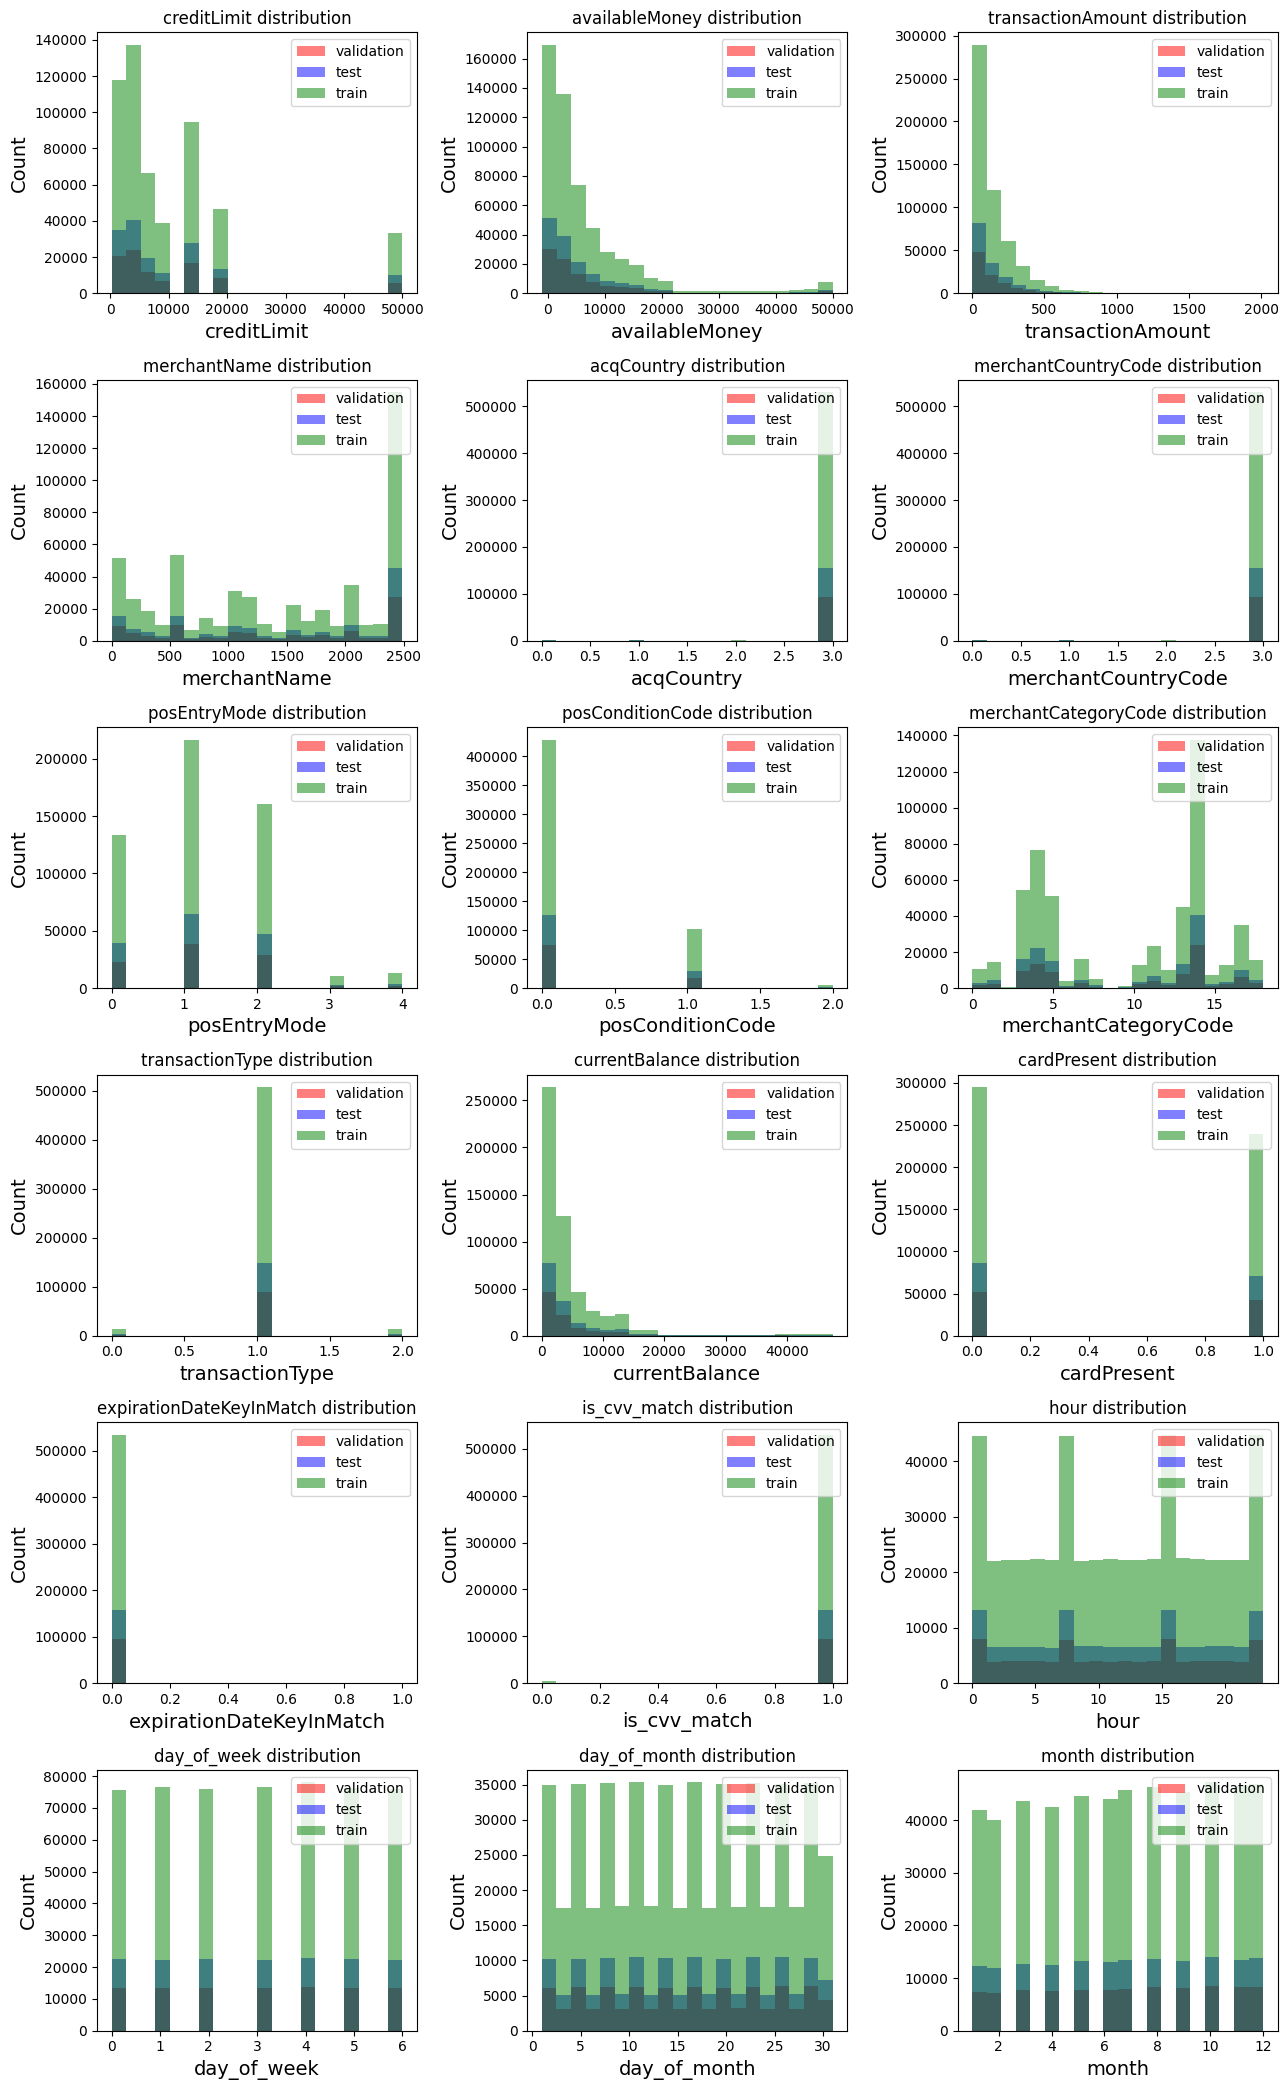

In [6]:
# Looking the data for test, training and validation set
X_test_plot = X_test[independent_cols]

X_val_plot = X_val[independent_cols]

X_train_plot = X_train[independent_cols]


######################################### Plots
n_cols = 3
n_rows = (len(X_test_plot.columns) + n_cols - 1) // n_cols  # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 3.5 * n_rows))  # figsize for better spacing

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(X_test_plot.columns[:]):
    axes[i].hist(X_val_plot[col], bins=20, alpha=0.5, label="validation", color='r')
    axes[i].hist(X_test_plot[col], bins=20, alpha=0.5, label="test", color='b')
    axes[i].hist(X_train_plot[col], bins=20, alpha=0.5, label="train", color='g')
    axes[i].set_xlabel(col, size=14)
    axes[i].set_ylabel("Count", size=14)
    axes[i].legend(loc='upper right')
    axes[i].set_title("{} distribution".format(col))

# Remove any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


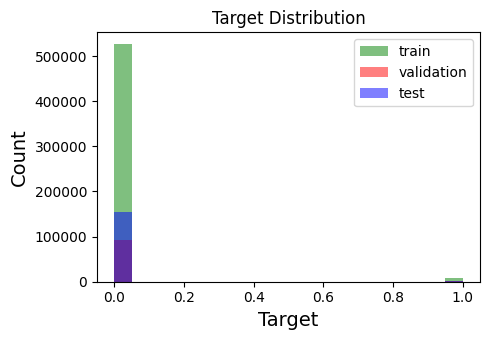

In [7]:
n_cols = 1
n_rows = 1 

fig, ax = plt.subplots(n_rows, n_cols, figsize=(5, 3.5))

# Plot the target distribution for each dataset
ax.hist(y_train, bins=20, alpha=0.5, label="train", color='g')
ax.hist(y_val, bins=20, alpha=0.5, label="validation", color='r')
ax.hist(y_test, bins=20, alpha=0.5, label="test", color='b')

# Set labels and title
ax.set_xlabel("Target", size=14)
ax.set_ylabel("Count", size=14)
ax.legend(loc='upper right')
ax.set_title("Target Distribution")

plt.tight_layout() 
plt.show()


#### Do the training and test sets have the same distribution?

Yes, from above graphs its evident that the distributions are same for all train , test and validation sets. If the ditributions are different, we can use stratified sampling to achieve same distribution accross sets

# <b> <span style='color:#0386f7de'>|</span> Checking Skewness</b>

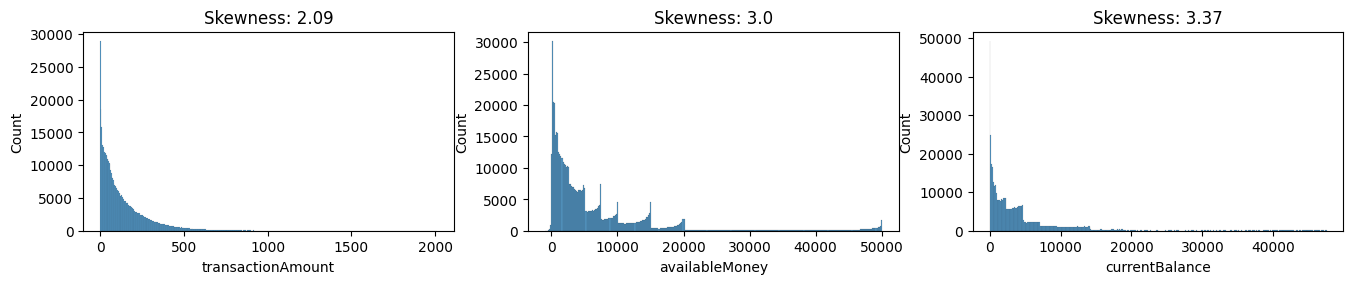

In [8]:
skewed_columns = ['transactionAmount', 'availableMoney', 'currentBalance']
plt.figure(figsize=(22,15))
k_pos=0
for i in skewed_columns:    
    k_pos=k_pos+1
    plt.subplot(5, 4,k_pos)    
    sns.histplot(X_train[i])
    plt.title('Skewness: '+str(X_train[i].skew().round(2)))

### Skewness

* `transactionAmount:` The histogram for transactionAmount shows a right-skewed distribution, with a long tail of higher values. This indicates that most transactions are relatively small, but there are some large transactions that pull the mean to the right
* `Other features:` Some other features also exhibit skewness, while others appear more symmetric.

In [9]:
def transform_skewed_features(train_df, test_df, val_df, features):
    boxcox_lambda = {}
    
    train = train_df.copy()
    test = test_df.copy()
    val = val_df.copy()

    for feature in features:
        min_value = train[feature].min()

        if min_value <= 0:
            shift = abs(min_value) + 1
            train[feature] += shift
            test[feature] += shift
            val[feature] += shift

        # Apply Box-Cox transformation to the training data and get lambda
        train[f'{feature}'], fitted_lambda = stats.boxcox(train[feature] + 1)  # Adding 1 to avoid log(0)
        # Store the lambda value
        boxcox_lambda[feature] = fitted_lambda
        
        # Apply the same Box-Cox transformation to test and validation data
        test[f'{feature}'] = stats.boxcox(test[feature] + 1, fitted_lambda)
        val[f'{feature}'] = stats.boxcox(val[feature] + 1, fitted_lambda)
    
    return train, test, val
    

In [10]:
skewed_feats_to_transform = ['transactionAmount', 'currentBalance', 'availableMoney']
X_train_transformed, X_test_transformed, X_val_transformed = transform_skewed_features(X_train, X_test, X_val, skewed_feats_to_transform)

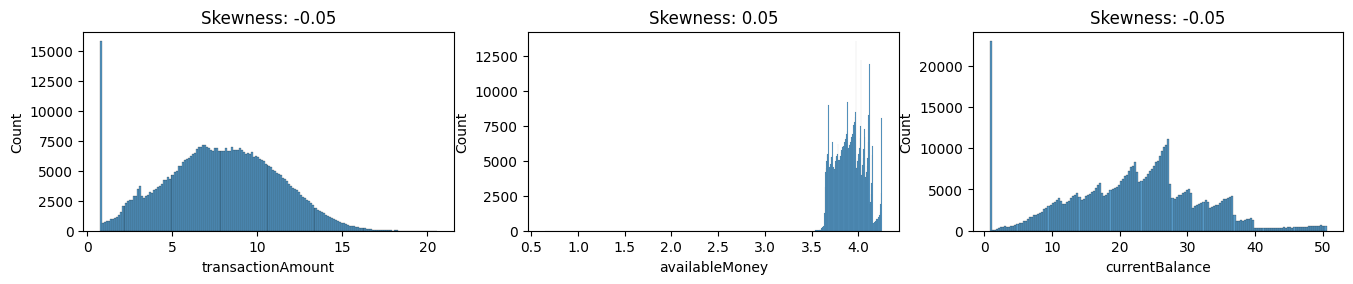

In [11]:
skewed_columns = ['transactionAmount', 'availableMoney', 'currentBalance']
plt.figure(figsize=(22,15))
k_pos=0
for i in skewed_columns:    
    k_pos=k_pos+1
    plt.subplot(5, 4,k_pos)    
    sns.histplot(X_train_transformed[i])
    plt.title('Skewness: '+str(X_train_transformed[i].skew().round(2)))

# <b> <span style='color:#0386f7de'>|</span> Credit Limit - Encoding (Ordinal)</b>


In [12]:
pd.set_option('future.no_silent_downcasting', True)

credit_limit_order = [250, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 50000]

credit_limit_order_mapping = {}

for i in range(len(credit_limit_order)):
    credit_limit_order_mapping[credit_limit_order[i]] = i


creditLimit_encoder = ce.OrdinalEncoder(cols=['creditLimit'], return_df=True, mapping=[{'col':'creditLimit',
 'mapping': credit_limit_order_mapping}])

X_train_transformed['creditLimit'] = creditLimit_encoder.fit_transform(X_train_transformed['creditLimit'])

### Transform both Test and Validation sets
X_test_transformed['creditLimit'] = creditLimit_encoder.transform(X_test_transformed['creditLimit'])
X_val_transformed['creditLimit'] = creditLimit_encoder.transform(X_val_transformed['creditLimit'])

# <b> <span style='color:#0386f7de'>|</span> Standardizing the Numerical features</b>


In [13]:
# Using StandardScaler to normalize the data
from sklearn.preprocessing import StandardScaler

numerical_feats = ['transactionAmount', 'availableMoney', 'currentBalance']

scaler = StandardScaler()
X_train_transformed[numerical_feats] = pd.DataFrame(scaler.fit_transform(X_train_transformed[numerical_feats].values), columns=numerical_feats, index=X_train_transformed.index)

## Transform Test and Val sets
X_test_transformed[numerical_feats] = pd.DataFrame(scaler.transform(X_test_transformed[numerical_feats].values), columns=numerical_feats, index=X_test_transformed.index)
X_val_transformed[numerical_feats] = pd.DataFrame(scaler.transform(X_val_transformed[numerical_feats].values), columns=numerical_feats, index=X_val_transformed.index)

X_train_transformed[numerical_feats].describe()

,transactionAmount,availableMoney,currentBalance
count,5.347260e+05,5.347260e+05,5.347260e+05
mean,5.207426e-16,4.734507e-17,4.131232e-16
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.111497e+00,-2.111910e+01,-2.171728e+00
25%,-6.818717e-01,-8.097932e-01,-6.553377e-01
50%,1.637897e-02,2.113053e-02,5.583938e-02
75%,7.182610e-01,7.496438e-01,6.041587e-01
max,3.814181e+00,2.170563e+00,2.864436e+00


### Now the data is ready for Model Training!!!

# <b> <span style='color:#0386f7de'>|</span> Model Training</b>

### Target distribution

`False`    98.420958

`True`      1.579042

Approximately `1.6%` of transactions are fraud which shows heavy imbalance. But, lets consider this distribution for model training as the usual case in real world is the same.

In [14]:


def display_confusion_matrix(y_pred, y_true):
    # Calculate confusion matrix and accuracy
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'\nAccuracy: {accuracy:.2f}')
    
    # Plot confusion matrix as a heatmap
    sns.heatmap(conf_matrix,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                annot_kws={"size": 20}
                )
    plt.show()

def plot_roc_curves(models):
    for label, (true_labels, pred_probs) in models.items():
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        sns.lineplot(x=fpr, y=tpr, label=label)

    # Add a diagonal line for random classifier
    diagonal_line = sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="grey")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [15]:
def model_prediction(model, X_train, y_train, X_test, y_test, model_name, models_results, result_df, feature_selection, class_balancing):
    model.fit( X_train, y_train)
    print("###########################################################################################")
    print(f"-----------------Classification report for {model_name} using Train data-----------------")
    print("###########################################################################################")
    y_pred = model.predict(X_train)
    print(classification_report(y_train, y_pred))
    print("###########################################################################################")
    print(f"-----------------Classification report for {model_name} using Test data-----------------")
    print("###########################################################################################")
    y_test_pred = model.predict(X_test)
    print(classification_report(y_test, y_test_pred))

    # Store the model's ROC curve data
    y_test_proba = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    auc_test = round(auc(fpr_test, tpr_test),2)
    
    models_results[model_name] = (fpr_test, tpr_test, auc_test)
    # Calculating Precision and Recall on the train set
    train_precision = round(precision_score(y_train, y_pred), 2)
    train_recall = round(recall_score(y_train, y_pred), 2)
    # Calculating Precision and Recall on the test set
    test_precision = round(precision_score(y_test, y_test_pred),2)
    test_recall = round(recall_score(y_test, y_test_pred),2)
    # update the result dataframe
    new_row = {
        'Model': model_name,
        'Feature Selection': feature_selection,
        'Class Balancing': class_balancing,
        'AUC': auc_test,
        'Train_Precision': train_precision,
        'Train_Recall': train_recall,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall
    }
    result_df.loc[len(result_df)] = new_row




def plot_combined_roc(models_results):
    plt.figure(figsize=(10, 7))
    
    # Plot ROC curve for each model
    for model_name, (fpr, tpr, auc_value) in models_results.items():
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_value:.2f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for All Models')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
X_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157273 entries, 487254 to 581215
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               157273 non-null  int64  
 1   availableMoney            157273 non-null  float64
 2   transactionAmount         157273 non-null  float64
 3   merchantName              157273 non-null  int64  
 4   acqCountry                157273 non-null  int64  
 5   merchantCountryCode       157273 non-null  int64  
 6   posEntryMode              157273 non-null  int64  
 7   posConditionCode          157273 non-null  int64  
 8   merchantCategoryCode      157273 non-null  int64  
 9   transactionType           157273 non-null  int64  
 10  currentBalance            157273 non-null  float64
 11  cardPresent               157273 non-null  int64  
 12  expirationDateKeyInMatch  157273 non-null  int64  
 13  is_cvv_match              157273 non-null  i

## Logistic Regression

In [17]:
# Finding best parameter
num_folds = KFold(n_splits=5, shuffle=True, random_state=4)
# parameters for cross validation
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
grid_model = GridSearchCV(estimator = LogisticRegression(),param_grid = parameters, scoring= 'roc_auc', verbose = 1,
                        cv = num_folds, 
                        return_train_score=True) 

grid_model.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [18]:
models_results = {} # dict to store all models results

In [19]:
# X_test_transformed[X_test_transformed.isna().any(axis=1)]
X_test_transformed.fillna(0, inplace=True)

In [20]:
logistic_model = LogisticRegression(C= 0.1)
X_test_transformed.fillna(0)
#model, X_train, y_train, X_test, y_test, model_name, models_results, result_df, feature_selection, class_balancing):
model_prediction(logistic_model, X_train_transformed, y_train, X_test_transformed, y_test, "Logistic Regression", models_results, result_df, "False", "False")


###########################################################################################
-----------------Classification report for Logistic Regression using Train data-----------------
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    526265
           1       0.00      0.00      0.00      8461

    accuracy                           0.98    534726
   macro avg       0.49      0.50      0.50    534726
weighted avg       0.97      0.98      0.98    534726

###########################################################################################
-----------------Classification report for Logistic Regression using Test data-----------------
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154856
   

## Random Forest

In [21]:
# Hyper Parameter tuning to find the best params
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100,200,300], 
    'max_features': [10, 20],
}
random_forest_model = RandomForestClassifier()
randon_grid_search = GridSearchCV(estimator = random_forest_model, param_grid = param_grid, cv = 2,n_jobs = -1,verbose = 1, 
                           return_train_score=True)

randon_grid_search.fit(X_train_transformed, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10, 5), 'max_features': [10, 20],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, verbose=1)

In [22]:
print("############################ Best HyperParameters #############################")
print(f'Best Accuracy: {randon_grid_search.best_score_} and Best Parameters {randon_grid_search.best_params_}')

############################ Best HyperParameters #############################
Best Accuracy: 0.9841769429577016 and Best Parameters {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [23]:
rfc_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=10,
                             n_estimators=200)


model_prediction(rfc_model, X_train_transformed, y_train, X_test_transformed, y_test, "Random Forest", models_results, result_df, "False", "False")
# plot_combined_roc(models_results)

###########################################################################################
-----------------Classification report for Random Forest using Train data-----------------
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    526265
           1       0.00      0.00      0.00      8461

    accuracy                           0.98    534726
   macro avg       0.49      0.50      0.50    534726
weighted avg       0.97      0.98      0.98    534726

###########################################################################################
-----------------Classification report for Random Forest using Test data-----------------
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154856
           1   

## CatBoost

In [24]:
X_train.columns

Index(['creditLimit', 'availableMoney', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'is_cvv_match', 'hour',
       'day_of_week', 'day_of_month', 'month'],
      dtype='object')

In [25]:
categorical_feats = [ 'creditLimit','merchantName','merchantCountryCode',
       'acqCountry', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'expirationDateKeyInMatch',
       'cardPresent', 'is_cvv_match', 'hour',
       'day_of_week', 'day_of_month','month']


# Create the CatBoost model
cbc_model = CatBoostClassifier(
    iterations=1000,  # Number of trees
    depth=6,  # Depth of the trees
    learning_rate=0.1,  # Learning rate
    loss_function='Logloss',  # Loss function for classification
    random_state=42
)


# Fit the model
cbc_model.fit(X_train_transformed, y_train, cat_features=categorical_feats, verbose=100) 

y_train_cb_pred = cbc_model.predict(X_train_transformed)

# Make predictions
y_test_cb_pred = cbc_model.predict(X_test_transformed)

# Evaluate the model
print("\nClassification Report:")
print("------------------------ Classification report for CatBoost on Train set -----------------------")
print(classification_report(y_train, y_train_cb_pred))




y_test_cb_proba = cbc_model.predict_proba(X_test_transformed)[:, 1]
fpr_test_cb, tpr_test_cb, _ = roc_curve(y_test, y_test_cb_proba)
auc_test_cb = round(auc(fpr_test_cb, tpr_test_cb),2)

# training precision and recall
train_precision_cb = round(precision_score(y_train, y_train_cb_pred), 2)
train_recall_cb = round(recall_score(y_train, y_train_cb_pred), 2)

models_results["catBoost"] = (fpr_test_cb, tpr_test_cb, auc_test_cb)
precision_cb = round(precision_score(y_test, y_test_cb_pred),2)
recall_cb = round(recall_score(y_test, y_test_cb_pred),2)
# update the result dataframe
new_row = {
    'Model': "CatBoost",
    'Feature Selection': "False",
    'Class Balancing': "False",
    'AUC': auc_test_cb,
    'Train_Precision': train_precision_cb,
    'Train_Recall': train_recall_cb,
    'Test_Precision': precision_cb,
    'Test_Recall': recall_cb
}
result_df.loc[len(result_df)] = new_row


0:	learn: 0.5143405	total: 172ms	remaining: 2m 51s
100:	learn: 0.0703199	total: 22.1s	remaining: 3m 16s
200:	learn: 0.0693950	total: 44.6s	remaining: 2m 57s
300:	learn: 0.0687636	total: 1m 8s	remaining: 2m 38s
400:	learn: 0.0682320	total: 1m 31s	remaining: 2m 16s
500:	learn: 0.0678514	total: 1m 55s	remaining: 1m 54s
600:	learn: 0.0674576	total: 2m 18s	remaining: 1m 31s
700:	learn: 0.0671155	total: 2m 40s	remaining: 1m 8s
800:	learn: 0.0667654	total: 3m 5s	remaining: 46s
900:	learn: 0.0664226	total: 3m 28s	remaining: 22.9s
999:	learn: 0.0660856	total: 3m 51s	remaining: 0us

Classification Report:
------------------------ Classification report for CatBoost on Train set -----------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    526265
           1       0.94      0.20      0.34      8461

    accuracy                           0.99    534726
   macro avg       0.96      0.60      0.66    534726
weighted avg       0.99     

In [26]:
print("------------------------ Classification report for CatBoost on Test set -----------------------")
print(classification_report(y_test, y_test_cb_pred))

------------------------ Classification report for CatBoost on Test set -----------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    154856
           1       0.61      0.03      0.06      2417

    accuracy                           0.98    157273
   macro avg       0.80      0.51      0.52    157273
weighted avg       0.98      0.98      0.98    157273



## Decision Tree

In [27]:
# Initializing and training
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
model_prediction(dt_model, X_train_transformed, y_train, X_test_transformed, y_test, "Decision Tree", models_results, result_df, "False", "False")


###########################################################################################
-----------------Classification report for Decision Tree using Train data-----------------
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    526265
           1       0.86      0.04      0.07      8461

    accuracy                           0.98    534726
   macro avg       0.92      0.52      0.53    534726
weighted avg       0.98      0.98      0.98    534726

###########################################################################################
-----------------Classification report for Decision Tree using Test data-----------------
###########################################################################################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154856
           1   

In [28]:
result_df

,Model,Feature Selection,Class Balancing,AUC,Train_Precision,Train_Recall,Test_Precision,Test_Recall
0,Logistic Regression,True,True,0.70,0.65,0.66,0.64,0.66
1,Random Forest,True,True,0.73,0.70,0.64,0.69,0.61
2,CatBoost,True,True,0.74,0.71,0.70,0.67,0.67
3,Decision Tree,True,True,0.70,0.72,0.73,0.64,0.66
4,Logistic Regression,True,False,0.70,0.00,0.00,0.00,0.00
5,Random Forest,True,False,0.73,0.00,0.00,0.00,0.00
6,CatBoost,True,False,0.74,0.80,0.00,0.00,0.00
7,Decision Tree,True,False,0.72,0.96,0.02,0.06,0.00
8,Logistic Regression,False,True,0.69,0.65,0.65,0.63,0.64
9,Random Forest,False,True,0.74,0.68,0.70,0.66,0.69


In [29]:
result_df.to_csv("data/result_df.csv",index = False)

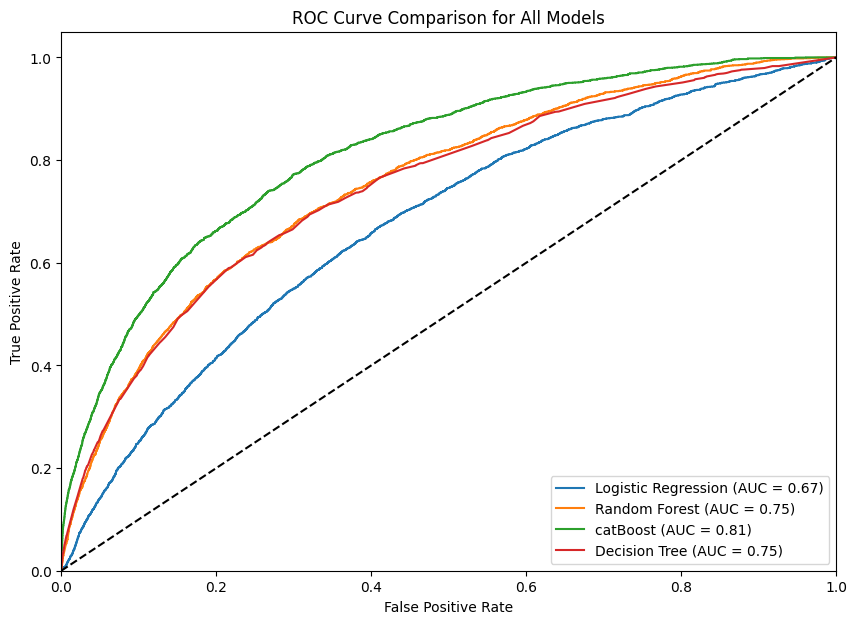

In [30]:
plot_combined_roc(models_results)